## This Notebook is implemented several undersampling methods for imbalanced NLP data, and applied to Random Forest for prediction.
## 1. NearMiss (version =3) undersampling technique for majority class, train acc 0.86, validation acc 0.11.
## 2. Condensed Nearest Neighbor Rule Undersampling, train acc 0.88, validation acc 0.51.
## 3. Tomek Links for Undersampling, train acc 0.91, validation acc 0.77.
## 4. Edited Nearest Neighbors Rule for Undersampling, train acc 0.9999, validation acc 0.77. 
## 5. One-Sided Selection for Undersampling, train acc 0.93, validation acc 0.58
## 6. Neighborhood Cleaning Rule for Undersampling, train acc 0.9996, validation acc 0.72.

## Data is downloaded from this public GitHub repo:

https://github.com/MarletteFunding/marlette-ds-challenge2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload data from Google Drive

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

## Explore the data, Visulization target (Scores), handle missing data

In [3]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0
2,584193040,1909902,service,0,7,10.0
3,584203035,1910310,Thanks!,198,205,10.0
4,584200037,1910006,Thank you!,58,68,10.0


In [4]:
df_train.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70657,689569033,3973028,good communication on each step,25,56,8.0
70659,689548036,3972918,Applying for this loan was a very easy experience,0,49,10.0
70660,689549033,3973010,Was very helpful and stayed on phone to make s...,0,103,10.0
70661,689564034,3973230,High Interest Rates,0,19,8.0
70662,689550033,3973221,I appreciate this loan opportunity from Best E...,63,120,10.0


In [5]:
df_validate.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
7,584207033,1910601,The loan process was super easy,0,31,10.0
10,584199033,1909801,The process was quick and easy!,0,31,9.0
13,591377035,2116637,were in my bank within just a few days from th...,178,252,10.0
14,591377035,2116635,"I do not know what you mean by ""my score"", but...",0,131,10.0
25,34211545,359794,Very expensive dental work and debt consolidat...,0,50,10.0


In [6]:
df_validate.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70650,689544034,3973218,Also many options to choose from to fit my bud...,28,78,10.0
70652,689568034,3972921,paying bills,0,12,10.0
70655,689550034,3973223,It was quick and easy process,0,29,10.0
70656,689559033,3973021,Best Egg helped me to consolidate my high inte...,40,136,10.0
70658,689559033,3973023,Having paid off those loans and now needing an...,188,300,10.0


In [7]:
df_train.shape

(56644, 6)

In [8]:
df_validate.shape

(14019, 6)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56644 entries, 0 to 70662
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DOCUMENT_ID         56644 non-null  int64  
 1   SENTENCE_ID         56644 non-null  int64  
 2   SENTENCE            56623 non-null  object 
 3   SENTENCE_START_POS  56644 non-null  int64  
 4   SENTENCE_END_POS    56644 non-null  int64  
 5   SCORE               56644 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.0+ MB


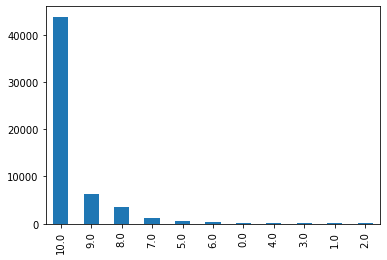

In [10]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df_train['SCORE'].value_counts().plot(kind = 'bar')

In [41]:
df_train['SCORE'].value_counts()

10.0    43832
9.0      6212
8.0      3625
7.0      1297
5.0       516
6.0       433
0.0       227
4.0       192
3.0       127
1.0        83
2.0        79
Name: SCORE, dtype: int64

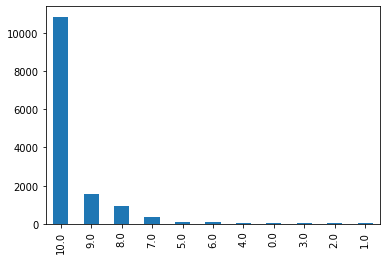

In [11]:
df_validate['SCORE'].value_counts().plot(kind = 'bar')

In [42]:
df_validate['SCORE'].value_counts()

10.0    10864
9.0      1562
8.0       904
7.0       332
5.0       111
6.0        97
4.0        46
0.0        35
3.0        26
2.0        20
1.0        17
Name: SCORE, dtype: int64

In [25]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
clean_text            0
dtype: int64

In [13]:
#Remove the missing data 
df_train = df_train.dropna()

In [26]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
clean_text            0
dtype: int64

In [15]:
df_train.shape

(56623, 6)

In [16]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [17]:
df_validate = df_validate.dropna()

In [27]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
clean_text            0
dtype: int64

In [19]:
df_validate.shape

(14014, 6)

## Preprocess Sentences

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [21]:
# Define preprocess function, remove stop words and punctuations etc.
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I Thank you!")

'thank'

In [22]:
# Clean train dataset
df_train["SENTENCE"] = df_train["SENTENCE"].astype("str")
df_train["clean_text"] = df_train["SENTENCE"].apply(clean_text)

In [23]:
# Clean validate dataset
df_validate["SENTENCE"] = df_validate["SENTENCE"].astype("str")
df_validate["clean_text"] = df_validate["SENTENCE"].apply(clean_text)

In [24]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly
2,584193040,1909902,service,0,7,10.0,service
3,584203035,1910310,Thanks!,198,205,10.0,thanks
4,584200037,1910006,Thank you!,58,68,10.0,thank


In [28]:
#save cleaned data to Google drive
df_train.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_train.csv')
df_validate.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [ ]:
#upload the cleaned data
#df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_validation = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

## Random Forest Prediction
### Using imblearn.under_sampling NearMiss to undersampling.


In [97]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [98]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

## Install Imbalanced-learn

In [32]:
!pip install imbalanced-learn

In [33]:
from imblearn.under_sampling import NearMiss

In [99]:
undersample = NearMiss(version=3, sampling_strategy='majority', n_neighbors_ver3=3)
#undersample = NearMiss(version=3, sampling_strategy='all', n_neighbors_ver3=3)

In [100]:
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

In [101]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

### Training Classification_report, Accuracy, 

In [102]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       227
         1.0       0.95      0.95      0.95        83
         2.0       0.99      0.84      0.90        79
         3.0       0.98      0.88      0.93       127
         4.0       0.99      0.88      0.93       192
         5.0       0.96      0.84      0.90       516
         6.0       0.98      0.80      0.88       433
         7.0       0.92      0.75      0.83      1297
         8.0       0.87      0.73      0.80      3625
         9.0       0.83      0.97      0.89      6212
        10.0       0.96      0.95      0.96        79

    accuracy                           0.86     12870
   macro avg       0.95      0.86      0.90     12870
weighted avg       0.87      0.86      0.86     12870

0.8644910644910645


In [103]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[ 205    0    0    1    0    1    1    4    7    8    0]
 [   0   79    0    0    0    0    0    0    1    3    0]
 [   0    1   66    0    0    1    0    1    6    4    0]
 [   1    2    1  112    0    0    0    0    7    4    0]
 [   0    0    0    0  168    2    0    2    8   12    0]
 [   0    0    0    0    0  435    2    9   41   29    0]
 [   1    1    0    1    1    1  348    8   41   31    0]
 [   1    0    0    0    1    4    0  973  102  216    0]
 [   0    0    0    0    0    5    3   32 2642  941    2]
 [   1    0    0    0    0    2    0   24  161 6023    1]
 [   0    0    0    0    0    0    0    0    4    0   75]]


### Validation Classification Report, Accuracy

In [104]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.29      0.10      0.15        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.04      0.02      0.02       111
         6.0       0.05      0.01      0.02        97
         7.0       0.10      0.08      0.09       332
         8.0       0.12      0.26      0.16       904
         9.0       0.11      0.83      0.20      1562
        10.0       0.82      0.00      0.00     10864

    accuracy                           0.11     14014
   macro avg       0.14      0.12      0.06     14014
weighted avg       0.66      0.11      0.04     14014

0.11231625517339804


In [105]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[   0    0    0    0    0    0    0    4   13   17    1]
 [   0    0    0    0    0    0    0    0   11    6    0]
 [   1    0    2    0    0    0    0    2    6    9    0]
 [   0    0    1    0    1    1    2    0   12    9    0]
 [   1    0    0    0    0    1    0    3   16   25    0]
 [   1    0    0    1    1    2    0   11   40   55    0]
 [   2    0    0    1    0    1    1   11   45   36    0]
 [   2    1    0    0    0    5    1   28   94  201    0]
 [   1    1    0    2    0    6    4   34  233  623    0]
 [   0    1    0    1    1    5    1   29  224 1299    1]
 [   9    5    4   10    4   32   12  148 1285 9346    9]]


## Condensed Nearest Neighbor Rule Undersampling


In [ ]:
#upload the cleaned data
import pandas as pd
df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
df_validate = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [106]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

In [108]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [109]:
# slow, takes 1 h or more
undersample = CondensedNearestNeighbour(n_neighbors=1)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)


In [110]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

In [111]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85        54
         1.0       0.86      0.86      0.86        14
         2.0       1.00      0.81      0.90        79
         3.0       0.97      0.90      0.94        83
         4.0       0.83      0.84      0.83        57
         5.0       0.90      0.67      0.77       115
         6.0       0.93      0.56      0.70        91
         7.0       0.84      0.65      0.73       169
         8.0       0.68      0.70      0.69       251
         9.0       0.94      0.87      0.90       539
        10.0       0.88      0.98      0.93      1389

    accuracy                           0.88      2841
   macro avg       0.88      0.79      0.83      2841
weighted avg       0.88      0.88      0.87      2841

0.8764519535374868


In [112]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  45    0    0    0    1    0    1    1    2    1    3]
 [   1   12    0    0    1    0    0    0    0    0    0]
 [   0    1   64    1    0    1    0    1    4    1    6]
 [   1    1    0   75    0    0    0    0    5    0    1]
 [   0    0    0    0   48    1    0    2    3    0    3]
 [   1    0    0    0    1   77    1    5   18    0   12]
 [   0    0    0    1    2    2   51    4   12    2   17]
 [   1    0    0    0    2    3    0  110   30    3   20]
 [   2    0    0    0    1    1    2    6  176    6   57]
 [   1    0    0    0    1    0    0    1    3  467   66]
 [   0    0    0    0    1    1    0    1    5   16 1365]]


In [113]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.02      0.03      0.02        35
         1.0       0.00      0.00      0.00        17
         2.0       0.17      0.10      0.12        20
         3.0       0.01      0.08      0.01        26
         4.0       0.00      0.02      0.01        46
         5.0       0.02      0.02      0.02       111
         6.0       0.06      0.02      0.03        97
         7.0       0.04      0.04      0.04       332
         8.0       0.09      0.04      0.05       904
         9.0       0.12      0.34      0.18      1562
        10.0       0.78      0.60      0.68     10864

    accuracy                           0.51     14014
   macro avg       0.12      0.12      0.11     14014
weighted avg       0.63      0.51      0.55     14014

0.505209076637648


In [114]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[   1    0    1    0    1    1    0    2    7    4   18]
 [   0    0    1    0    0    0    1    0    2    1   12]
 [   1    0    2    1    1    1    0    1    1    2   10]
 [   0    0    0    2    2    2    0    1    2    0   17]
 [   1    0    0    2    1    0    0    0    1    5   36]
 [   4    0    0    4    6    2    0    3    8   12   72]
 [   2    0    0    2    1    1    2    3   20   11   55]
 [   4    2    1    9   12   11    2   12   20   63  196]
 [   8    0    3   12   17   10    3   37   32  300  482]
 [   6    0    1   30   25    7    6   30   36  534  887]
 [  26    1    3  193  170   47   17  219  222 3474 6492]]


## Tomek Links for Undersampling


In [115]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [119]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

In [117]:
from imblearn.under_sampling import TomekLinks

In [120]:
undersample = TomekLinks()
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)


In [121]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)
rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

In [123]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93       198
         1.0       0.96      0.89      0.92        73
         2.0       1.00      0.81      0.90        79
         3.0       0.97      0.87      0.92       113
         4.0       0.99      0.84      0.91       160
         5.0       0.97      0.78      0.87       439
         6.0       0.97      0.75      0.85       372
         7.0       0.94      0.63      0.76      1105
         8.0       0.90      0.56      0.69      3202
         9.0       0.95      0.48      0.64      5534
        10.0       0.90      1.00      0.95     42776

    accuracy                           0.91     54051
   macro avg       0.95      0.77      0.85     54051
weighted avg       0.91      0.91      0.89     54051

0.9052561469723039


In [124]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  176     0     0     0     0     0     0     4     7     0    11]
 [    0    65     0     1     0     0     0     0     1     0     6]
 [    0     1    64     1     0     1     0     1     4     1     6]
 [    2     1     0    98     0     0     0     0     6     0     6]
 [    0     0     0     0   135     2     0     3     5     0    15]
 [    1     0     0     0     0   344     2     7    32     4    49]
 [    2     0     0     1     0     1   279     3    20     3    63]
 [    0     0     0     0     0     2     2   699    55     7   340]
 [    0     0     0     0     0     2     2    13  1786    28  1371]
 [    1     1     0     0     1     1     2     4    31  2680  2813]
 [    0     0     0     0     1     3     1    12    43   112 42604]]


In [125]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.50      0.05      0.09        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.07      0.01      0.02       111
         6.0       0.17      0.03      0.05        97
         7.0       0.23      0.05      0.08       332
         8.0       0.27      0.06      0.10       904
         9.0       0.19      0.02      0.04      1562
        10.0       0.79      0.98      0.88     10864

    accuracy                           0.77     14014
   macro avg       0.20      0.11      0.11     14014
weighted avg       0.66      0.77      0.69     14014

0.7688739831596975


In [126]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    0     0     0     0     0     0     1     2     7     0    25]
 [    0     0     0     0     0     0     1     0     3     1    12]
 [    1     0     1     0     0     0     0     1     2     0    15]
 [    0     0     0     0     0     1     0     1     1     0    23]
 [    1     0     0     0     0     0     1     0     1     1    42]
 [    0     0     0     1     0     1     1     3    15     2    88]
 [    2     0     0     0     2     0     3     3    23     2    62]
 [    1     1     0     1     0     2     1    15    24    11   276]
 [    1     1     0     0     0     2     6    18    56    30   790]
 [    0     0     0     1     1     2     0     7    16    36  1499]
 [    3     2     1     2     0     6     4    14    58   111 10663]]


## Edited Nearest Neighbors Rule for Undersampling



In [127]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [128]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest=vectorizer.transform(xtest)

In [129]:
from imblearn.under_sampling import EditedNearestNeighbours

In [130]:
undersample = EditedNearestNeighbours(n_neighbors=3)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)


In [131]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)

In [132]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

In [133]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         2.0       1.00      0.97      0.99        79
         4.0       1.00      1.00      1.00         2
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00        61
         9.0       1.00      1.00      1.00        62
        10.0       1.00      1.00      1.00     22231

    accuracy                           1.00     22437
   macro avg       1.00      1.00      1.00     22437
weighted avg       1.00      1.00      1.00     22437

0.9999108615233766


In [134]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[   77     0     0     0     0     2]
 [    0     2     0     0     0     0]
 [    0     0     2     0     0     0]
 [    0     0     0    61     0     0]
 [    0     0     0     0    62     0]
 [    0     0     0     0     0 22231]]


In [135]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.02      0.10      0.03        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.00      0.00      0.00       111
         6.0       0.00      0.00      0.00        97
         7.0       0.00      0.00      0.00       332
         8.0       0.16      0.01      0.03       904
         9.0       0.13      0.00      0.01      1562
        10.0       0.78      0.99      0.87     10864

    accuracy                           0.77     14014
   macro avg       0.10      0.10      0.09     14014
weighted avg       0.63      0.77      0.68     14014

0.7690880548023405


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    0     0     7     0     0     0     0     0     0     0    28]
 [    0     0     2     0     0     0     0     0     0     0    15]
 [    0     0     2     0     0     0     0     0     0     0    18]
 [    0     0     2     0     0     0     0     0     0     0    24]
 [    0     0     0     0     0     0     0     0     0     0    46]
 [    0     0     8     0     0     0     0     0     2     0   101]
 [    0     0    13     0     0     0     0     0     1     0    83]
 [    0     0    10     0     0     0     0     0     7     1   314]
 [    0     0    15     0     0     0     0     0    13     5   871]
 [    0     0    13     0     0     0     0     0    13     6  1530]
 [    0     0    28     0     0     0     0     0    46    33 10757]]


## Combinations of Keep and Delete Methods
### One-Sided Selection for Undersampling


In [138]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [143]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest = vectorizer.transform(xtest)

In [141]:
from imblearn.under_sampling import OneSidedSelection

In [144]:
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

In [145]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

### Evaluation the Train dataset and Validation dataset

In [147]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       198
         1.0       0.98      0.96      0.97       200
         2.0       0.98      0.82      0.90        79
         3.0       0.99      0.87      0.93       193
         4.0       0.94      0.90      0.92       196
         5.0       0.96      0.77      0.86       222
         6.0       0.96      0.79      0.86       226
         7.0       0.91      0.64      0.75       269
         8.0       0.83      0.81      0.82       949
         9.0       0.93      0.75      0.83      1195
        10.0       0.93      0.99      0.96      7699

    accuracy                           0.93     11426
   macro avg       0.95      0.84      0.89     11426
weighted avg       0.93      0.93      0.93     11426

0.9290215298442149


In [148]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[ 182    0    0    0    1    1    1    0    7    1    5]
 [   0  193    0    0    0    0    0    0    3    1    3]
 [   0    1   65    1    0    1    0    1    4    1    5]
 [   0    2    0  167    0    0    1    0   11    2   10]
 [   0    0    0    0  177    1    0    0    4    0   14]
 [   0    0    0    0    1  172    2    2   28    2   15]
 [   0    0    0    0    1    0  178    2   18    2   25]
 [   1    0    0    0    3    3    0  171   40    9   42]
 [   1    0    0    0    3    0    3    6  764   23  149]
 [   1    0    0    0    1    1    1    4   21  897  269]
 [   0    1    1    0    1    0    0    2   20   25 7649]]


In [151]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.02      0.01      0.01       111
         6.0       0.02      0.01      0.01        97
         7.0       0.02      0.02      0.02       332
         8.0       0.09      0.10      0.09       904
         9.0       0.12      0.19      0.15      1562
        10.0       0.78      0.72      0.75     10864

    accuracy                           0.58     14014
   macro avg       0.10      0.09      0.09     14014
weighted avg       0.63      0.58      0.60     14014

0.5842728699871557


In [152]:
cm = (confusion_matrix(ytest,ypred))
print(cm)

[[   0    1    1    1    1    0    0    2    8    1   20]
 [   0    0    1    1    0    0    1    2    2    0   10]
 [   1    1    0    1    0    0    0    1    2    0   14]
 [   0    0    0    0    0    3    0    1    0    0   22]
 [   1    1    0    0    0    0    0    0    2    3   39]
 [   3    2    0    3    4    1    1    1   15    6   75]
 [   3    1    0    0    0    0    1    6   21    6   59]
 [   2    2    1    2    2    4    2    7   31   49  230]
 [   4    5    0    4    6    5    5   15   89  158  613]
 [   3    5    0    4    2    7    4   42  118  294 1083]
 [  11   26    1   18   15   23   32  251  752 1939 7796]]


## Neighborhood Cleaning Rule for Undersampling

In [153]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [154]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain = vectorizer.fit_transform(xtrain)
xtest = vectorizer.transform(xtest)

In [155]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [156]:
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain,ytrain)

RandomForestClassifier(n_estimators=50)

In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        26
         1.0       1.00      1.00      1.00         2
         2.0       1.00      0.87      0.93        79
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00        12
         5.0       0.97      1.00      0.98        62
         6.0       1.00      1.00      1.00        24
         7.0       1.00      0.99      1.00       105
         8.0       1.00      0.99      1.00       538
         9.0       1.00      1.00      1.00       560
        10.0       1.00      1.00      1.00     37616

    accuracy                           1.00     39027
   macro avg       1.00      0.98      0.99     39027
weighted avg       1.00      1.00      1.00     39027

0.9995644041304738


In [159]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[   25     0     0     0     0     0     0     0     0     0     1]
 [    0     2     0     0     0     0     0     0     0     0     0]
 [    0     0    69     0     0     2     0     0     2     0     6]
 [    0     0     0     3     0     0     0     0     0     0     0]
 [    0     0     0     0    12     0     0     0     0     0     0]
 [    0     0     0     0     0    62     0     0     0     0     0]
 [    0     0     0     0     0     0    24     0     0     0     0]
 [    0     0     0     0     0     0     0   104     0     0     1]
 [    0     0     0     0     0     0     0     0   535     0     3]
 [    0     0     0     0     0     0     0     0     0   558     2]
 [    0     0     0     0     0     0     0     0     0     0 37616]]


In [160]:
ypred=rf.predict(xtest)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.06      0.05      0.06        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.11      0.05      0.07       111
         6.0       0.05      0.01      0.02        97
         7.0       0.10      0.02      0.03       332
         8.0       0.13      0.10      0.11       904
         9.0       0.13      0.04      0.06      1562
        10.0       0.79      0.92      0.85     10864

    accuracy                           0.72     14014
   macro avg       0.12      0.11      0.11     14014
weighted avg       0.64      0.72      0.67     14014

0.7240616526330812


In [161]:
cm = (confusion_matrix(ytest,ypred))
print(cm)

[[   0    0    2    1    0    4    0    0    1    0   27]
 [   0    0    1    0    0    1    0    0    1    0   14]
 [   1    0    1    0    0    1    0    0    0    0   17]
 [   0    0    2    0    0    0    0    0    1    0   23]
 [   0    0    1    0    0    1    0    0    1    1   42]
 [   3    0    0    1    1    6    0    2    6    0   92]
 [   1    0    1    0    1   12    1    3    4    2   72]
 [   1    0    2    1    2   10    2    5   22   15  272]
 [   2    0    1    1    3    9    1   12   89   42  744]
 [   1    1    2    0    0    4    2    5   96   64 1387]
 [   0    4    3    0    1    5   13   25  447  385 9981]]


# Summary and Improvement:

## 1. NearMiss reduced the majority size from more than 40k to 79 which is smallest size of minority classes. So the performance is not good, especially validation acc is very low.
## 2. Condensed Nearest Neighbor Rule performs better than NearMiss, but data treansform takes longer time, and accuracy is not good enough.
## 3. Tomek Links performs the same as no undersampling. 
## 4. Edited Nearest Neighbors Rule outperformance other algorithms, but removed half of minority classes; removed classes might be ambigues or noises, need to study and understand them.
## 5. Neighborhood Cleaning Rule keeps all minority classes, the train acc is very high, but validation acc slightly lower.
## Improvement:      
## 1. Understand the domain knowledge of dataset, which may help the data preprocessing.
## 2. Make sure the data is correctly labeled which is very challenge for text data; high quality data is very important for the algorithm performance and predictions.
